# Mask R-CNN - Train on Simple Baby Dataset

Modification of the Shapes Training sample.

# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
import skimage

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Configurations

In [2]:
class BabiesConfig(Config):
    """Configuration for training on the babies dataset.
    Derives from the base Config class and overrides values specific
    to the babies dataset.
    """
    # Give the configuration a recognizable name
    NAME = "babies"
    
    # Backbone network architecture
    # Supported values are: resnet50, resnet101.
    # You can also provide a callable that should have the signature
    # of model.resnet_graph. If you do so, you need to supply a callable
    # to COMPUTE_BACKBONE_SHAPE as well
    BACKBONE = "resnet50"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    
    USE_MINI_MASK = False

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 70

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
    LEARNING_RATE = 0.001
    
config = BabiesConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
class BabiesDataset(utils.Dataset):
    """Generates the babies dataset.
    """

    def load_babies(self, count, validation=False):
        """Generate the requested number of images.
        count: number of images to generate.
        validation: whether this is validation set.
        """
        # Add classes
        self.add_class("babies", 1, "baby")
        
        image_dir = 'Images'
        if validation:
            image_dir = os.path.join(image_dir, 'Validation')
        else:
            image_dir = os.path.join(image_dir, 'Training')

        # Add images
        for i in range(count):
            image_path = os.path.join(image_dir, '{}.png'.format(i))
            image = skimage.io.imread(image_path)
            if image.shape[2] == 4:
                image = image[:,:,:3]
            
            self.add_image("babies", image_id=i, path=image_path,
                           height=image.shape[0], width=image.shape[1])

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        elif info["source"] == "babies":
            return info
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        image_path = info['path']
        validation_path = image_path.replace('.png', '.labels.tif')
        mask = skimage.io.imread(validation_path)
        mask = mask.reshape((mask.shape[0], mask.shape[1], 1))
        class_ids = np.array([1], np.int32)
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [5]:
# Training dataset
dataset_train = BabiesDataset()
dataset_train.load_babies(28)
dataset_train.prepare()

# Validation dataset
dataset_val = BabiesDataset()
dataset_val.load_babies(5, validation=True)
dataset_val.prepare()

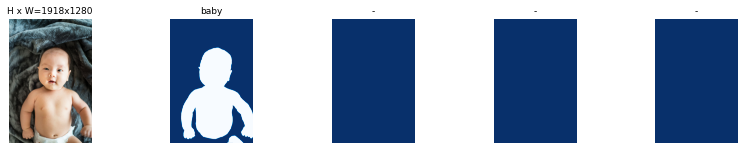

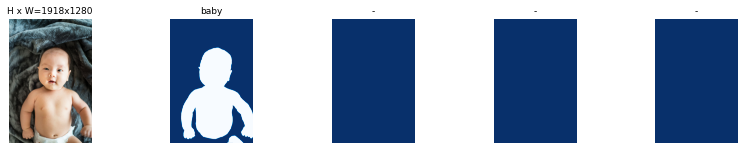

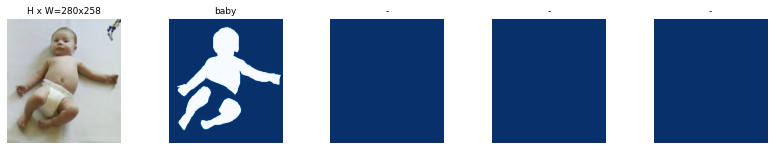

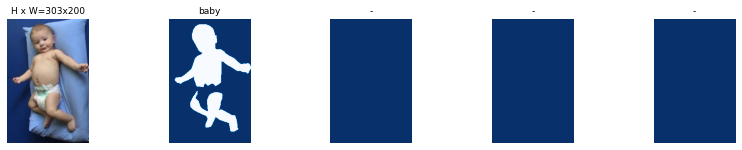

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [7]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [8]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [9]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=15, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/svu/e0201435/Mask_RCNN/logs/babies20210224T0354/mask_rcnn_babies_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrc

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


70/70 [==============================] - 60s 852ms/step - loss: 1.0116 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.2949 - mrcnn_class_loss: 0.0531 - mrcnn_bbox_loss: 0.3024 - mrcnn_mask_loss: 0.3290 - val_loss: 0.7992 - val_rpn_class_loss: 0.0029 - val_rpn_bbox_loss: 0.3114 - val_mrcnn_class_loss: 0.0088 - val_mrcnn_bbox_loss: 0.2708 - val_mrcnn_mask_loss: 0.2054
Epoch 2/15
48/70 [===================>..........] - ETA: 12s - loss: 0.4061 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0814 - mrcnn_class_loss: 0.0970 - mrcnn_bbox_loss: 0.0941 - mrcnn_mask_loss: 0.1313WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.147900). Check your callbacks.


70/70 [==============================] - 41s 579ms/step - loss: 0.3697 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0686 - mrcnn_class_loss: 0.0937 - mrcnn_bbox_loss: 0.0815 - mrcnn_mask_loss: 0.1236 - val_loss: 0.9845 - val_rpn_class_loss: 0.0016 - val_rpn_bbox_loss: 0.4187 - val_mrcnn_class_loss: 0.1944 - val_mrcnn_bbox_loss: 0.2037 - val_mrcnn_mask_loss: 0.1661
Epoch 3/15
14/70 [=====>........................] - ETA: 23s - loss: 0.2603 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0343 - mrcnn_class_loss: 0.0653 - mrcnn_bbox_loss: 0.0511 - mrcnn_mask_loss: 0.1082WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.153687). Check your callbacks.


44/70 [=================>............] - ETA: 11s - loss: 0.2645 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0393 - mrcnn_class_loss: 0.0631 - mrcnn_bbox_loss: 0.0576 - mrcnn_mask_loss: 0.1030WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.156845). Check your callbacks.


70/70 [==============================] - 34s 479ms/step - loss: 0.2482 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0340 - mrcnn_class_loss: 0.0603 - mrcnn_bbox_loss: 0.0514 - mrcnn_mask_loss: 0.1010 - val_loss: 0.8594 - val_rpn_class_loss: 0.0015 - val_rpn_bbox_loss: 0.3539 - val_mrcnn_class_loss: 0.1433 - val_mrcnn_bbox_loss: 0.1987 - val_mrcnn_mask_loss: 0.1619
Epoch 4/15
 6/70 [=>............................] - ETA: 26s - loss: 0.2072 - rpn_class_loss: 7.5812e-04 - rpn_bbox_loss: 0.0238 - mrcnn_class_loss: 0.0524 - mrcnn_bbox_loss: 0.0364 - mrcnn_mask_loss: 0.0939WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.151028). Check your callbacks.


39/70 [===============>..............] - ETA: 13s - loss: 0.1912 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0184 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.0300 - mrcnn_mask_loss: 0.0931WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.153366). Check your callbacks.


65/70 [==========================>...] - ETA: 2s - loss: 0.1774 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0140 - mrcnn_class_loss: 0.0450 - mrcnn_bbox_loss: 0.0274 - mrcnn_mask_loss: 0.0899WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.165560). Check your callbacks.


70/70 [==============================] - 34s 483ms/step - loss: 0.1748 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0134 - mrcnn_class_loss: 0.0436 - mrcnn_bbox_loss: 0.0272 - mrcnn_mask_loss: 0.0894 - val_loss: 0.7526 - val_rpn_class_loss: 0.0013 - val_rpn_bbox_loss: 0.3460 - val_mrcnn_class_loss: 0.0811 - val_mrcnn_bbox_loss: 0.1613 - val_mrcnn_mask_loss: 0.1629
Epoch 5/15
29/70 [===========>..................] - ETA: 18s - loss: 0.1459 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0067 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.0213 - mrcnn_mask_loss: 0.0853WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.159180). Check your callbacks.


58/70 [=======================>......] - ETA: 5s - loss: 0.1528 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0131 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.0235 - mrcnn_mask_loss: 0.0845WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.160233). Check your callbacks.


70/70 [==============================] - 36s 508ms/step - loss: 0.1532 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0129 - mrcnn_class_loss: 0.0323 - mrcnn_bbox_loss: 0.0232 - mrcnn_mask_loss: 0.0837 - val_loss: 0.8498 - val_rpn_class_loss: 0.0010 - val_rpn_bbox_loss: 0.3888 - val_mrcnn_class_loss: 0.1067 - val_mrcnn_bbox_loss: 0.1924 - val_mrcnn_mask_loss: 0.1608
Epoch 6/15
22/70 [========>.....................] - ETA: 21s - loss: 0.1319 - rpn_class_loss: 7.2556e-04 - rpn_bbox_loss: 0.0061 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0183 - mrcnn_mask_loss: 0.0773WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.163764). Check your callbacks.


50/70 [====================>.........] - ETA: 9s - loss: 0.1256 - rpn_class_loss: 8.1116e-04 - rpn_bbox_loss: 0.0069 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.0173 - mrcnn_mask_loss: 0.0753WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.163341). Check your callbacks.


70/70 [==============================] - 36s 513ms/step - loss: 0.1264 - rpn_class_loss: 8.1905e-04 - rpn_bbox_loss: 0.0064 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.0169 - mrcnn_mask_loss: 0.0748 - val_loss: 0.7774 - val_rpn_class_loss: 7.3784e-04 - val_rpn_bbox_loss: 0.3535 - val_mrcnn_class_loss: 0.1092 - val_mrcnn_bbox_loss: 0.1654 - val_mrcnn_mask_loss: 0.1486
Epoch 7/15
11/70 [===>..........................] - ETA: 22s - loss: 0.1302 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0064 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.0153 - mrcnn_mask_loss: 0.0768WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.163628). Check your callbacks.


38/70 [===============>..............] - ETA: 14s - loss: 0.1391 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0170 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0204 - mrcnn_mask_loss: 0.0771    WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.174090). Check your callbacks.


65/70 [==========================>...] - ETA: 2s - loss: 0.1306 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0118 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.0172 - mrcnn_mask_loss: 0.0745WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.167915). Check your callbacks.


70/70 [==============================] - 35s 506ms/step - loss: 0.1289 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0113 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.0166 - mrcnn_mask_loss: 0.0741 - val_loss: 0.8689 - val_rpn_class_loss: 9.9795e-04 - val_rpn_bbox_loss: 0.3711 - val_mrcnn_class_loss: 0.1648 - val_mrcnn_bbox_loss: 0.1790 - val_mrcnn_mask_loss: 0.1530
Epoch 8/15
26/70 [==========>...................] - ETA: 21s - loss: 0.1095 - rpn_class_loss: 9.1276e-04 - rpn_bbox_loss: 0.0049 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0107 - mrcnn_mask_loss: 0.0705WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.166620). Check your callbacks.


52/70 [=====================>........] - ETA: 8s - loss: 0.1061 - rpn_class_loss: 9.3202e-04 - rpn_bbox_loss: 0.0036 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.0095 - mrcnn_mask_loss: 0.0686WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.170085). Check your callbacks.


70/70 [==============================] - 38s 541ms/step - loss: 0.1020 - rpn_class_loss: 8.8258e-04 - rpn_bbox_loss: 0.0030 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0084 - mrcnn_mask_loss: 0.0679 - val_loss: 0.7898 - val_rpn_class_loss: 9.1728e-04 - val_rpn_bbox_loss: 0.3685 - val_mrcnn_class_loss: 0.1026 - val_mrcnn_bbox_loss: 0.1498 - val_mrcnn_mask_loss: 0.1680
Epoch 9/15
13/70 [====>.........................] - ETA: 24s - loss: 0.0818 - rpn_class_loss: 7.5261e-04 - rpn_bbox_loss: 9.4503e-04 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.0043 - mrcnn_mask_loss: 0.0620WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.176315). Check your callbacks.


40/70 [================>.............] - ETA: 14s - loss: 0.0861 - rpn_class_loss: 5.5760e-04 - rpn_bbox_loss: 0.0011 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0046 - mrcnn_mask_loss: 0.0642WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.177794). Check your callbacks.


67/70 [===========================>..] - ETA: 1s - loss: 0.0879 - rpn_class_loss: 5.7120e-04 - rpn_bbox_loss: 0.0011 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0644WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.178918). Check your callbacks.


70/70 [==============================] - 38s 537ms/step - loss: 0.0891 - rpn_class_loss: 5.9830e-04 - rpn_bbox_loss: 0.0011 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0644 - val_loss: 0.8516 - val_rpn_class_loss: 0.0010 - val_rpn_bbox_loss: 0.4022 - val_mrcnn_class_loss: 0.0705 - val_mrcnn_bbox_loss: 0.2070 - val_mrcnn_mask_loss: 0.1708
Epoch 10/15
28/70 [===========>..................] - ETA: 24s - loss: 0.0938 - rpn_class_loss: 5.6119e-04 - rpn_bbox_loss: 0.0018 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.0084 - mrcnn_mask_loss: 0.0650WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.180606). Check your callbacks.


55/70 [======================>.......] - ETA: 8s - loss: 0.0885 - rpn_class_loss: 5.3529e-04 - rpn_bbox_loss: 0.0015 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.0067 - mrcnn_mask_loss: 0.0633WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.180253). Check your callbacks.


70/70 [==============================] - 40s 578ms/step - loss: 0.0875 - rpn_class_loss: 5.3141e-04 - rpn_bbox_loss: 0.0014 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.0064 - mrcnn_mask_loss: 0.0631 - val_loss: 0.8543 - val_rpn_class_loss: 6.3133e-04 - val_rpn_bbox_loss: 0.4046 - val_mrcnn_class_loss: 0.1090 - val_mrcnn_bbox_loss: 0.1784 - val_mrcnn_mask_loss: 0.1616
Epoch 11/15
16/70 [=====>........................] - ETA: 24s - loss: 0.0860 - rpn_class_loss: 7.3684e-04 - rpn_bbox_loss: 0.0014 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0062 - mrcnn_mask_loss: 0.0605WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.184895). Check your callbacks.


42/70 [=================>............] - ETA: 13s - loss: 0.0863 - rpn_class_loss: 6.5203e-04 - rpn_bbox_loss: 0.0027 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.0064 - mrcnn_mask_loss: 0.0632WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.181600). Check your callbacks.


69/70 [============================>.] - ETA: 0s - loss: 0.0883 - rpn_class_loss: 6.3887e-04 - rpn_bbox_loss: 0.0029 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0063 - mrcnn_mask_loss: 0.0616WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.208369). Check your callbacks.


70/70 [==============================] - 37s 535ms/step - loss: 0.0881 - rpn_class_loss: 6.4969e-04 - rpn_bbox_loss: 0.0029 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0063 - mrcnn_mask_loss: 0.0615 - val_loss: 0.9211 - val_rpn_class_loss: 0.0011 - val_rpn_bbox_loss: 0.4161 - val_mrcnn_class_loss: 0.1787 - val_mrcnn_bbox_loss: 0.1514 - val_mrcnn_mask_loss: 0.1738
Epoch 12/15
30/70 [===========>..................] - ETA: 19s - loss: 0.0818 - rpn_class_loss: 5.0231e-04 - rpn_bbox_loss: 0.0024 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0600WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.191303). Check your callbacks.


56/70 [=======================>......] - ETA: 6s - loss: 0.0835 - rpn_class_loss: 6.0327e-04 - rpn_bbox_loss: 0.0017 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0584WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.187735). Check your callbacks.


70/70 [==============================] - 38s 540ms/step - loss: 0.0851 - rpn_class_loss: 5.8230e-04 - rpn_bbox_loss: 0.0016 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0585 - val_loss: 0.8345 - val_rpn_class_loss: 6.9176e-04 - val_rpn_bbox_loss: 0.3681 - val_mrcnn_class_loss: 0.1387 - val_mrcnn_bbox_loss: 0.1549 - val_mrcnn_mask_loss: 0.1720
Epoch 13/15
17/70 [======>.......................] - ETA: 24s - loss: 0.0828 - rpn_class_loss: 5.0540e-04 - rpn_bbox_loss: 0.0015 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0576WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.191402). Check your callbacks.


44/70 [=================>............] - ETA: 12s - loss: 0.0852 - rpn_class_loss: 5.1743e-04 - rpn_bbox_loss: 0.0017 - mrcnn_class_loss: 0.0206 - mrcnn_bbox_loss: 0.0058 - mrcnn_mask_loss: 0.0566WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.188344). Check your callbacks.


70/70 [==============================] - 38s 540ms/step - loss: 0.0853 - rpn_class_loss: 4.8143e-04 - rpn_bbox_loss: 0.0018 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.0060 - mrcnn_mask_loss: 0.0573 - val_loss: 0.8691 - val_rpn_class_loss: 0.0015 - val_rpn_bbox_loss: 0.3792 - val_mrcnn_class_loss: 0.1135 - val_mrcnn_bbox_loss: 0.1962 - val_mrcnn_mask_loss: 0.1786


Epoch 14/15
31/70 [============>.................] - ETA: 19s - loss: 0.0746 - rpn_class_loss: 5.0716e-04 - rpn_bbox_loss: 0.0019 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0540WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.192770). Check your callbacks.


58/70 [=======================>......] - ETA: 6s - loss: 0.0753 - rpn_class_loss: 4.7459e-04 - rpn_bbox_loss: 0.0019 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0535WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.193791). Check your callbacks.


70/70 [==============================] - 38s 547ms/step - loss: 0.0742 - rpn_class_loss: 4.6322e-04 - rpn_bbox_loss: 0.0018 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0533 - val_loss: 0.8384 - val_rpn_class_loss: 7.4304e-04 - val_rpn_bbox_loss: 0.3721 - val_mrcnn_class_loss: 0.1235 - val_mrcnn_bbox_loss: 0.1571 - val_mrcnn_mask_loss: 0.1850
Epoch 15/15
19/70 [=======>......................] - ETA: 23s - loss: 0.0793 - rpn_class_loss: 2.8661e-04 - rpn_bbox_loss: 0.0018 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0042 - mrcnn_mask_loss: 0.0570WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.190718). Check your callbacks.


46/70 [==================>...........] - ETA: 12s - loss: 0.0737 - rpn_class_loss: 4.5971e-04 - rpn_bbox_loss: 0.0015 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0039 - mrcnn_mask_loss: 0.0535WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.240623). Check your callbacks.


70/70 [==============================] - 38s 538ms/step - loss: 0.0736 - rpn_class_loss: 4.5946e-04 - rpn_bbox_loss: 0.0013 - mrcnn_class_loss: 0.0147 - mrcnn_bbox_loss: 0.0037 - mrcnn_mask_loss: 0.0534 - val_loss: 0.8592 - val_rpn_class_loss: 5.7866e-04 - val_rpn_bbox_loss: 0.3555 - val_mrcnn_class_loss: 0.1620 - val_mrcnn_bbox_loss: 0.1545 - val_mrcnn_mask_loss: 0.1865


In [10]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 40,
            epochs=8, 
            layers="all")


Starting at epoch 15. LR=2.5e-05

Checkpoint Path: /home/svu/e0201435/Mask_RCNN/logs/babies20210224T0354/mask_rcnn_babies_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)


In [11]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [12]:
class InferenceConfig(BabiesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/svu/e0201435/Mask_RCNN/logs/babies20210224T0354/mask_rcnn_babies_0015.h5
Re-starting from epoch 15


original_image           shape: (256, 256, 3)         min:    0.00000  max:  237.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max:  280.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:    2.00000  max:  252.00000  int32
gt_mask                  shape: (256, 256, 1)         min:    0.00000  max:    1.00000  bool


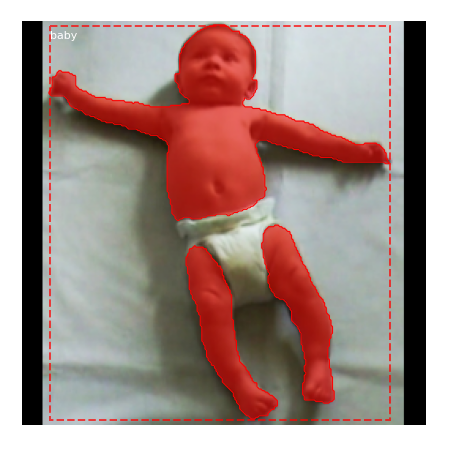

In [13]:
# Test on a training image
image_id = random.choice(dataset_train.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_train, inference_config, 
                           image_id)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  237.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  133.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


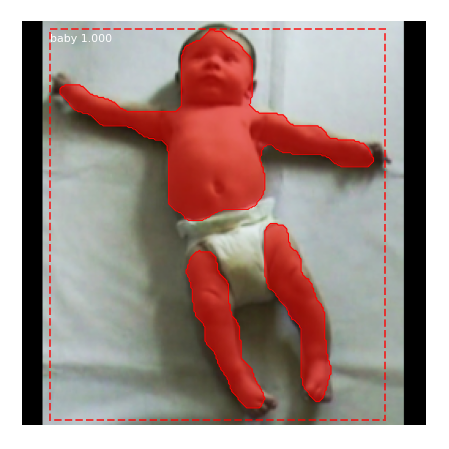

In [14]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

original_image           shape: (256, 256, 3)         min:   14.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max:  256.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:   55.00000  max:  213.00000  int32
gt_mask                  shape: (256, 256, 1)         min:    0.00000  max:    1.00000  bool


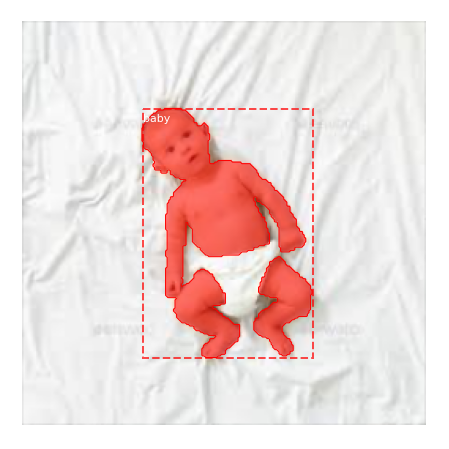

In [15]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (256, 256, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min:  -89.90000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


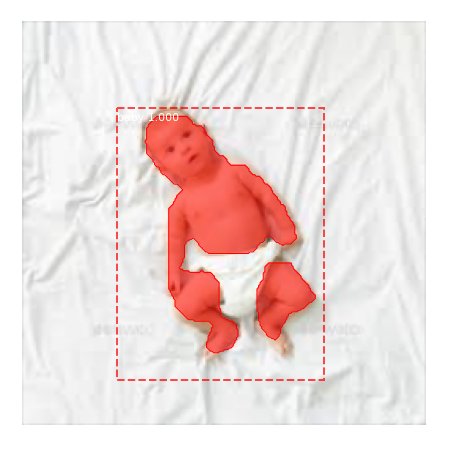

In [16]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [17]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  1.0
